In [1]:
%matplotlib inline
from time import time
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
# nicer looking default plots
plt.style.use('bmh')

# Libraries to read data from NetCDF files
# xarray and netCDF4 can do much the same thing
# but xarray is slightly more high-level and has more features
# and is sometimes more annoying (in my opinion)
import xarray as xr
import netCDF4 as nc

# library for coordinate transformations
import pyproj

# Nice colormaps for oceanography, install from conda
import cmocean

In [2]:
#data = xr.open_dataset('../data/samples_NSEW_20130601-20130602.nc')
data = nc.Dataset('../data/samples_NSEW_20130601-20130602.nc')

# Get overview of contents
data
#data.variables['w_velocity']
#data.variables['u_east']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.5
    title: Current data from SINMOD
    institution: SINTEF Fisheries and Aquaculture
    grid_mapping: grid_mapping
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 53.3333320618
    coordinate_north_pole: [ 45241.   34517.5]
    latitude_of_projection_origin: 90.0
    standard_parallel: 60.0
    false_easting: 2412853.25
    false_northing: 1840933.25
    barotropic_timestep: 0.40000000596
    baroclinic_timestep: 10.0
    _FillValue: -32768
    setup: Fordefjorden53m
    relax_e: T
    nested: T
    tidal_input: F
    DHA: 0.1
    smagorin: T
    biharmonic: F
    KBi: 100000.0
    COLDSTART: F
    ATMODATA: 0
    CM: 0.8
    CM2D: 0.8
    CH: 0.3
    CI: 5.0
    icedyn: T
    tidal_components: [0 0 0 0 0 0 0 0]
    history: Mon Apr  9 10:06:27 2018: ncatted -O -a _FillValue,depth,o,s,-32768 data

/home/torn/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


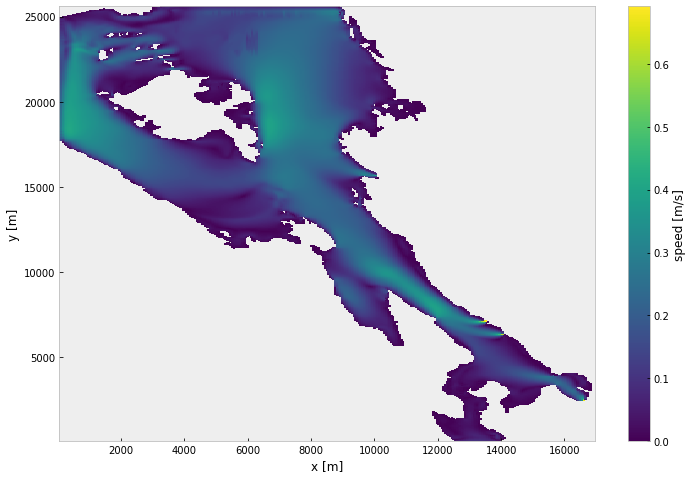

In [3]:

# Coordinates (unit m)
xc = np.array(data.variables['xc'][:])
yc = np.array(data.variables['yc'][:])
zc = np.array(data.variables['zc'][:])
# Time coordinate is given as "days since 2013-06-01 00:00"
# and must be converted to seconds
tc = np.array(data.variables['time'][:]) * 24*60*60

# Velocity components (unit m/s)
# The current components are stored as u_east, v_north and the weirdly named w_velocity, which is the z-component
u_east  = data.variables['u_east']
v_north = data.variables['v_north']
w_up    = data.variables['w_velocity']

# Calculate speed for surface layer
# order of indices are [t, z, y, x]
speed = np.sqrt(u_east[0,0,:,:]**2 + v_north[0,0,:,:]**2 + w_up[0,0,:,:]**2)

# Plot horizontal current speed
fig = plt.figure(figsize = (12, 8))
plt.pcolormesh(xc, yc, speed)
plt.colorbar(label = 'speed [m/s]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

In [4]:
# To calculate trajectories in the xyz-coordinate system,
# we need to rotate the horizontal components from east-north to x-y

# Array shapes
ny = u_east.shape[2]
nx = u_east.shape[3]

# Populate array with both east and north components
# for one layer and one timestep
NE = np.empty((ny, nx, 2))
NE[:,:,0] = u_east[0,0,:,:]
NE[:,:,1] = v_north[0,0,:,:]

# Get offset of coordinate system
# False easting and false northing
# (needed to rotate vectors for fetch calculation)
x0 = data.variables['grid_mapping'].false_easting
y0 = data.variables['grid_mapping'].false_northing

# Find rotation angle (different for each cell)
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]
x, y = np.meshgrid(xc, yc)
theta = np.arctan2(x0 - (x - dx/2), y0 - (y - dy/2))

# Construct rotation matrix
# (this is constant for all times and depths)
rot = np.empty((*theta.shape, 2, 2))
rot[:,:,0,0] =  np.cos(theta)
rot[:,:,0,1] =  np.sin(theta)
rot[:,:,1,0] = -np.sin(theta)
rot[:,:,1,1] =  np.cos(theta)

# rotate
XY = np.matmul(rot, NE[:,:,:,None])

print(XY.shape)

# Get x and y components separately
u = XY[:,:,0] # x component
v = XY[:,:,1] # y component

(480, 318, 2, 1)


(36, 20, 56, 57) (36, 20, 56, 57) (36, 20, 56, 57)


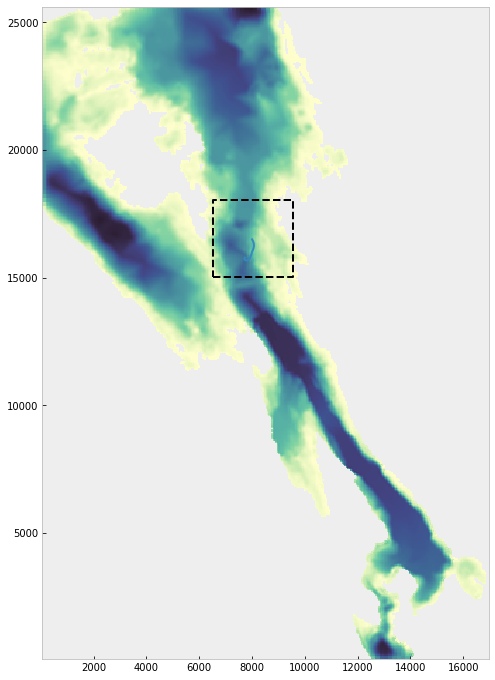

In [5]:
# Creating a rotated subset and calculating a trajectory
# using nearest-neighbour interpolation, to show an example

# Selecting xy subset bounds based on above plot
# showing coordinate axis in meters
imin = np.searchsorted(xc,  6500)
imax = np.searchsorted(xc,  9500)
jmin = np.searchsorted(yc, 15000)
jmax = np.searchsorted(yc, 18000)
# And top 20 layers and first 12 hours (36 timesteps)
Nt = 36
Nz = 20
Ny = jmax - jmin
Nx = imax - imin
u = np.zeros_like(u_east[:Nt, :Nz, jmin:jmax, imin:imax])
v = np.zeros_like(u_east[:Nt, :Nz, jmin:jmax, imin:imax])
# w can be used directly
# using np.array to convert from netCDF variable object
# (which behaves mostly like an array) to an actual array
w = np.array(w_up[:Nt, :Nz, jmin:jmax, imin:imax])

# Find rotation angle (different for each cell)
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]
x, y = np.meshgrid(xc[imin:imax], yc[jmin:jmax])
theta = np.arctan2(x0 - (x - dx/2), y0 - (y - dy/2))

# Construct rotation matrix
# (this is constant for all times and depths)
rot = np.empty((*theta.shape, 2, 2))
rot[:,:,0,0] =  np.cos(theta)
rot[:,:,0,1] =  np.sin(theta)
rot[:,:,1,0] = -np.sin(theta)
rot[:,:,1,1] =  np.cos(theta)

for l in range(Nt):
    for k in range(Nz):
        NE = np.empty((Ny, Nx, 2))
        NE[:,:,0] = u_east[l,k,jmin:jmax,imin:imax]
        NE[:,:,1] = v_north[l,k,jmin:jmax,imin:imax]
        
        # rotate
        XY = np.matmul(rot, NE[:,:,:,None])

        # Get x and y components separately
        u[l,k,:,:] = XY[:,:,0,0] # x component
        v[l,k,:,:] = XY[:,:,1,0] # y component
        

# callable object to return velocity
# using nearest-neighbour interpolation
class interpolator():
    def __init__(self, xc, yc, zc, tc, u, v, w):
        self.xc = xc
        self.yc = yc
        self.zc = zc
        self.tc = tc
        self.u  = u
        self.v  = v
        self.w  = w
        
    def __call__(self, X, t):
        # look up coordinates
        i = np.searchsorted(self.xc, X[0])
        j = np.searchsorted(self.yc, X[1])
        k = np.searchsorted(self.zc, X[2])
        l = np.searchsorted(self.tc, t)
        return np.array([self.u[l,k,j,i], self.v[l,k,j,i], self.w[l,k,j,i]])

# Heun's Method
def rk2(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    k1  = f(x,          t)
    k2  = f(x + k1*h,   t + h)
    # Update time and position
    x_ = x + h*(k1 + k2)/2
    return x_

def trajectory(X0, T0, Tmax, h, f, integrator):
    # Number of timesteps
    Nt   = int((Tmax) / h)
    # Add 2 for initial position and fractional step at end
    # X0.size lets X hold Nt+2 arrays of the same size as X0
    X0   = np.array(X0)
    X    = np.zeros((Nt+2, X0.size))
    T    = np.zeros(Nt+2)
    # Initialise
    X[0,:] = X0
    T[0]   = T0
    # Loop over timesteps
    t = T0
    for i in range(Nt+1):
        # Make sure the last step stops exactly at Tmax
        h  = min(h, Tmax - t)
        # Calculate next position
        X[i+1,:] = integrator(X[i,:], t, h, f)
        T[i+1] = T[i] + h
        # Increment time
        t += h
    return X, T


# Set initial position [x, y, z]
X0   = np.array([8000, 16500, 20])
# Initial and final time in seconds since start of file
T0   = 0
Tmax = 10*3600
# Timestep (in seconds)
h    = 1200

# Construct interpolator
f = interpolator(xc[imin:imax], yc[jmin:jmax], zc[:Nz], tc[:Nt], u, v, w)
Xs, Ts = trajectory(X0, T0, Tmax, h, f, rk2)

fig = plt.figure(figsize = (8, 12))
ax = fig.add_subplot(aspect = 'equal')
# Plot depth
plt.pcolormesh(xc, yc, data.variables['depth'], cmap = cmocean.cm.deep)
# plot outline of subset
plt.plot([xc[imin], xc[imax], xc[imax], xc[imin], xc[imin]], [yc[jmin], yc[jmin], yc[jmax], yc[jmax], yc[jmin]], '--', c = 'k')
# Plot trajectory (in xy-plane)
plt.plot(Xs[:,0], Xs[:,1])

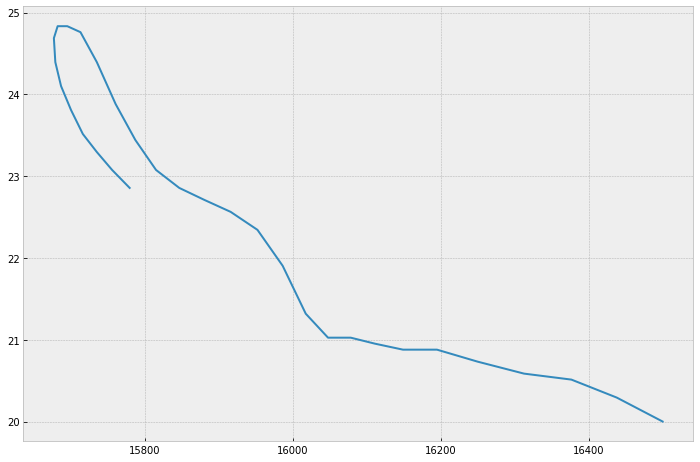

In [6]:
# Plotting in yz-plane
# Note large difference in scales
fig = plt.figure(figsize = (12, 8))
plt.plot(Xs[:,1], Xs[:,2])

# Map plots

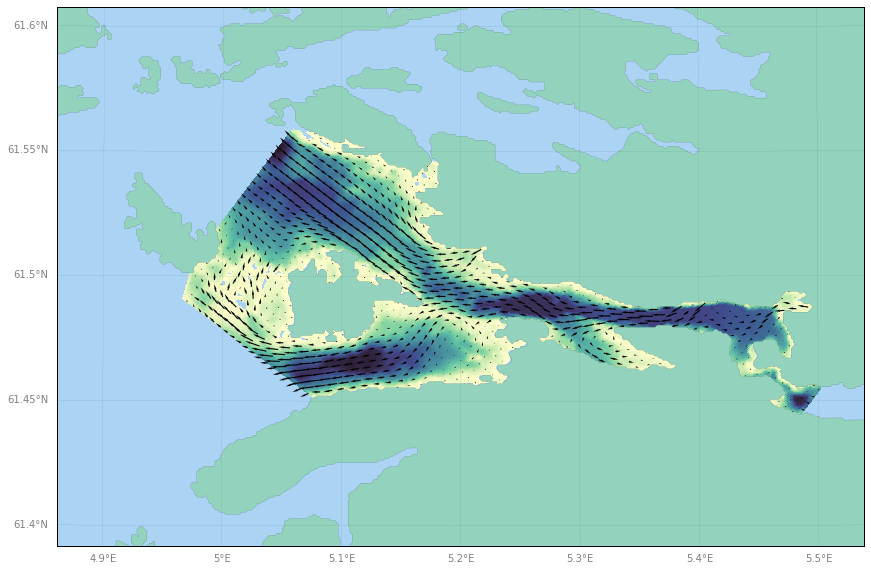

In [7]:
# Map plotting library
# requires installation of basemap from conda
# you may have to add the conda-forge repository
from mpl_toolkits.basemap import Basemap

# Create a figure object, and an axes instance, with projection info
fig = plt.figure(figsize=(12,8))
# Define some colors and variables, and create a map.
seacolor  = (171/255, 211/255, 244/255)
landcolor = (147/255, 211/255, 189/255)
lat_0  = 61.5 # Latitude of map center
lon_0  = 5.2  # Longitude of map center
scale  = 1.2  # change scale to change area covered by map
width  = 30000 * scale # width of map in meters
height = 20000 * scale # height of map in meters
m = Basemap(
    lat_0      = lat_0,   # Latitude at center of map
    lon_0      = lon_0,   # Longitude at center of map
    width      = width,   # Width of map (in meters)
    height     = height,  # Height of map (in meters)
    resolution = 'f',     # Resolution of coastlines, 'c'rude, 'l'ow, 'i'ntermediate, 'h'igh, 'f'ine
    projection = 'stere'  # Map projection, 'stere' is 'stereographic'
)

# Draw land, sea, parallels and meridians
linewidth = 0.1
alpha     = 0.5
# Fill background with seacolor
m.drawmapboundary(fill_color=seacolor)
# Fill continents with landcolor, and lakes with seacolor
m.fillcontinents(color=landcolor, lake_color=seacolor)
# Draw coastlines with a thin black line
m.drawcoastlines(linewidth = linewidth)
# draw grid of parallels and meridians.
m.drawparallels(np.arange(-90.,90,0.05), linewidth = linewidth, alpha = alpha, labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180,0.1), latmax = 90, linewidth = linewidth, alpha = alpha, labels=[0,0,0,1])

# Open the currentdata file
datapath = '../data/samples_NSEW_20130601-20130602.nc'
data = nc.Dataset(datapath)

# Coordinates (latitude and longitude)
lons = np.array(data.variables['gridLons'][:])
lats = np.array(data.variables['gridLats'][:])

# Velocity components (unit m/s)
u_east  = data.variables['u_east']
v_north = data.variables['v_north']

# Depth
depth = data.variables['depth']
# Plot depth using colormap especially crafted to convey deepness
# https://matplotlib.org/cmocean/
m.pcolormesh(lons, lats, depth[:,:], latlon = True, cmap = cmocean.cm.deep)

# plot vectorplot of currents (in the horizontal plane)
it = 0 # Time index
iz = 0 # Depth index
step = 7 # plot only every step vector
m.quiver(
    lons[::step, ::step], lats[::step,::step], # position of each vector
    u_east[it, iz, ::step, ::step], v_north[it, iz, ::step, ::step], # vector components
    latlon = True, width = 0.0014, headwidth = 2, scale = 20 # Some parameters to tweak appearance
    # See matplotlib docs for details:
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.quiver.html
)

# tight_layout doesn't work well with basemap, adjust manually
plt.subplots_adjust(left = 0.06, right = 0.995, bottom = 0.05, top = 0.99)
plt.savefig('currentmap.png', dpi = 120)